In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv("Q:/4. Learning/3nd year students/1. Data business analytics/Report Data Business Analytics/time-series-forecasting/Dataset/Microsoft_Stock.csv")
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

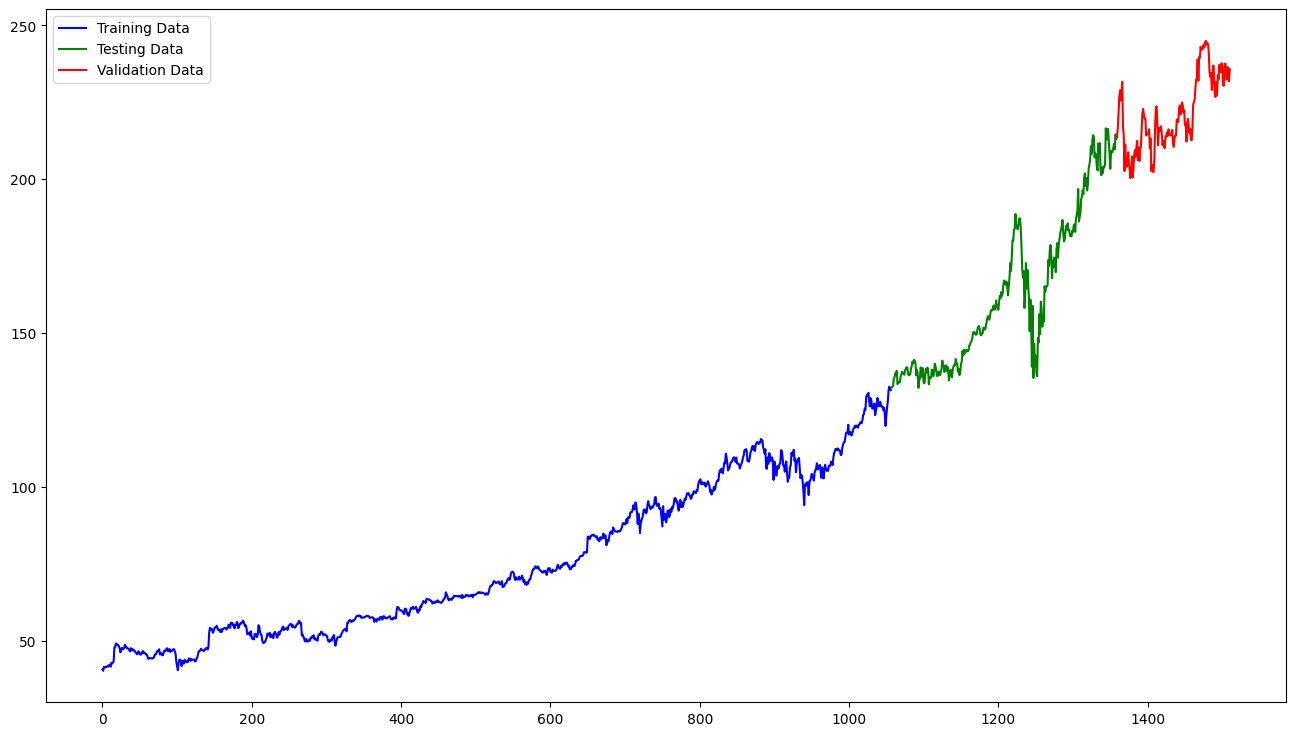

In [3]:
#Trực quan các tệp dữ liệu vừa chia
plt.figure(figsize=(16,9))
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.plot(val_data, 'red', label='Validation Data')
plt.legend()

In [8]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best SARIMAX model
import pmdarima as pm
#model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5285.137, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3729.348, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4482.755, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5387.715, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3968.131, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3619.928, Time=1.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=5261.727, Time=1.38 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3613.359, Time=2.33 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3724.815, Time=0.77 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=3

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True)

In [9]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [10]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[131.78758762 130.63966676 130.76051631 130.99728302 129.63240926
 131.24700896 131.01185416 131.09261712 133.33143925 133.15774086
 131.63471498 131.72511371 131.60925843 130.80113623 129.9188947
 130.09674881 128.62193658 130.75633542 131.24733634 131.50742294
 133.46809168 133.69902014 132.57757951 132.61829865 132.45778063
 131.20002413 131.23643027 130.86685453 128.52744851 130.71417933]


In [11]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 85.10778048319632
Testing RMSE: 26.93172373079063


Validation RMSE: 85.10778048319632
Testing RMSE: 26.93172373079063


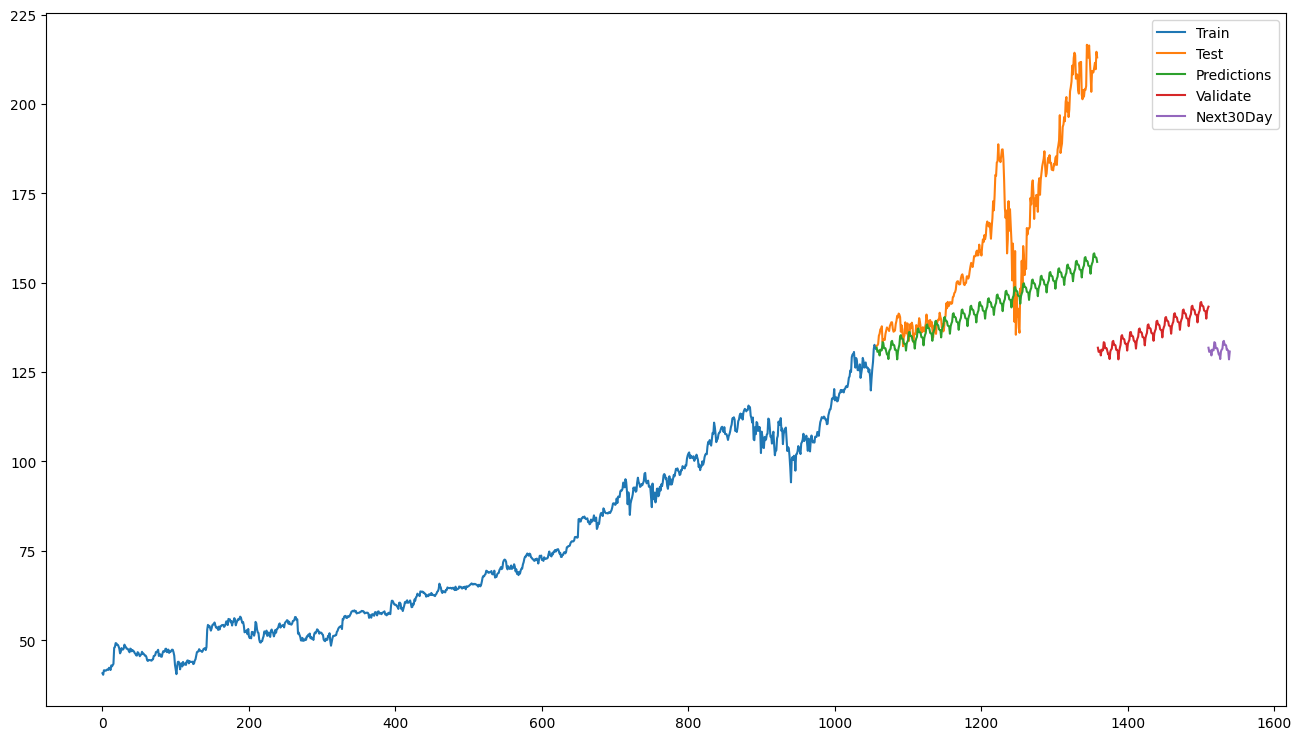

In [12]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [ ]:
test_data.index

RangeIndex(start=1057, stop=1359, step=1)